In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
dataDir='./coco'
# dataType='val2014'
dataType='train2014'
annFile='{}/annotations/sm_captions_{}.json'.format(dataDir,dataType)

In [3]:
print annFile
coco = COCO(annFile)

./coco/annotations/sm_captions_train2014.json
loading annotations into memory...
0:00:00.126915
creating index...
index created!


In [4]:
from sample import *
import torch
import argparse
from PIL import Image
import pickle
import time

In [5]:
class Args(object):
    def __init__(self, img_file_name, folder='val2014',hardpath=None):
        img_location = './coco/%s/%s'%(folder,img_file_name);
        if hardpath!=None:
            img_location = hardpath+"/"+img_file_name;
#         self.encoder_path = './models/encoder-5-3000.pkl'
#         self.decoder_path = './models/decoder-5-3000.pkl'
        self.encoder_path = './models/1_256_512_encoder-5-1001.pkl'
        self.decoder_path = './models/1_256_512_decoder-5-1001.pkl'
        self.vocab_path = './data/vocab.pkl'
        self.embed_size = 256
        self.hidden_size = 512;
        self.num_layers = 1;
        self.image = img_location;
        self.encoder = None;
        self.decoder = None;
        self.vocab = None;

    

5000
./data/resized2014/COCO_train2014_000000030038.jpg
[u'info', u'images', u'licenses', 'type', u'annotations']
[748454, 749012, 752089, 763630, 763888]
[u'image_id', u'id', u'caption']

a man and a woman excited over a box of donuts
Guy and girl smiling and posing at a diner with doughnutes.
A man and women pose smiling with coffee and a box of doughnuts at a doughnut shop.
The man and woman are smiling with a box of donuts.
A man holing a doughnut box open with a female standing beside him.


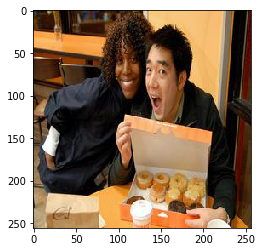

In [6]:
imgIds = coco.getImgIds()
print len(imgIds)
img = coco.loadImgs(imgIds[2])[0]
# args = Args(img['file_name'])
args = Args(img['file_name'], hardpath='./data/resized2014');
print args.image;
coco.dataset['type'] = None;
annIds = coco.getAnnIds(imgIds=[img['id']])
print annIds
ann = coco.loadAnns(annIds)
print ann[0].keys()
print ''
test = [x['caption'] for x in ann]
for sen in test:
    print sen

image = Image.open(args.image)
plt.imshow(np.asarray(image))

In [8]:
a_time = time.time()
caption, encoder, decoder, vocab = main(args, show_img=True)
print caption
caption = caption.replace('<start>','').replace('end>','')
print time.time()-  a_time
print caption;

AttributeError: 'module' object has no attribute '_cuda_getDevice'

In [ ]:
import json
N = 10000
m_cnt =0
cached_encoder = None;
cached_decoder = None;
cached_vocab = None;
gen_captions = []

try:        
    for i in range(N):
        if i%10 == 0: print '%s/%s'%(i,N);
        try:            
            img_id = imgIds[i];
            img = coco.loadImgs(img_id)[0];
            img_location = img['file_name'];
            args = Args(img_location);
            args.encoder = cached_encoder;
            args.decoder = cached_decoder;
            args.vocab = cached_vocab;
            caption, cached_encoder, cached_decoder, cached_vocab = main(args, show_img=False);
            caption = caption.replace('<start>','').replace('<end>','')
            img['caption'] = caption;
            gen_captions.append({'caption': caption, 'image_id': img_id});
        except Exception as e:
            m_cnt -= 1;
            print e;
except Exception as e:
    print 'outer exception', e;
finally:        
    cnt = len(gen_captions) - m_cnt;
    print 'generated %s/%s captions'%(cnt,N);
    data_json = json.dumps(gen_captions)
    with open('./generated_captions.json', 'wb') as handle:
        handle.write(data_json)        
    #         pickle.dump(gen_captions, handle, protocol=pickle.HIGHEST_PROTOCOL)
    



In [ ]:
with open('./generated_captions.pkl', 'r') as handle:
    aa = pickle.load(handle)
    print aa[0]

# EVALUATION


In [ ]:
from pycocoevalcap.eval import COCOEvalCap

In [ ]:
import json
# data_json = json.dumps(data)
# with open('./caption_result.json', 'wb') as handle:
# #     pickle.dump(res_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     handle.write(data_json)

with open('./generated_captions.json', 'r') as handle:
    r = handle.read()
    loaded_r = json.loads(r);
    print len(loaded_r)
    

# loaded_r = json.loads(r)
# loaded_r['rating'] #Output 3.5
# print type(r) #Output str
# print type(loaded_r) #Output dict


In [ ]:
cocoRes = coco.loadRes('./generated_captions.json')

In [ ]:
print 'N=', len(cocoRes.getImgIds())
cocoEval = COCOEvalCap(coco, cocoRes)

cocoEval.params['image_id'] = cocoRes.getImgIds()

# evaluate results
cocoEval.evaluate()


In [ ]:
print 'Number of evaluated image captions: ', len(cocoRes.getImgIds())
for metric, score in cocoEval.eval.items():
    print '%s: %.3f'%(metric, score)

In [ ]:
print loaded_r

In [ ]:
img = coco.loadImgs(132059)[0]
print img

In [ ]:
I = io.imread('./coco/val2014/%s'%(img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()